# Exploratory Analysis and Predictive Modeling of Diabetes Among Pima Indian Women 

### Background
Diabetes, a complex metabolic disease marked by decreased production or function of insulin, has become a major global health concern (Banday et al., 2020). Its prevalence has grown and affects many different populations all around the world. Notably, a great deal of study has been conducted on diabetes because of its complex nature, which includes genetic, environmental, and lifestyle components. Some groups, like the Pima Indians, have shown a disproportionately high incidence of diabetes. This Native American population in the southwest of the United States has an exceptionally high incidence rate, which emphasises the necessity for targeted investigations into the unique factors influencing diabetes within this demographic.

### Research Question: How well can we predict the likelihood of diabetes among Pima Indian women based on certain health-related features?

<u>Dataset Description:</u><br>
Our chosen dataset, the Pima Indians Diabetes dataset, serves as a valuable resource for unravelling the 
intricate dynamics of diabetes among Pima Indian women. Composing a comprehensive set of health parameters, including glucose levels,
blood pressure, skin thickness, insulin levels, BMI, and age, this dataset encapsulates the complexity of factors contributing to 
diabetes risk. The 'Outcome' variable, indicating the presence or absence of diabetes, is of particular significance.
This binary classification enables us to frame our predictive modelling and exploratory analysis within a context that directly 
aligns with our research question. The richness and specificity of this dataset empower us to delve deeply into the unique 
characteristics of Pima Indian women and explore how these factors interplay in the manifestation of diabetes within this community.

### Methods and Description
<u>Data Loading:</u> <br>We began by retrieving the dataset from its original source on the web. The dataset was imported into R using the read_csv function from the tidyverse package.

<u>Data Cleaning and Wrangling:</u> <br>Once loaded, we cleaned and wrangled the data to prepare it for analysis. We converted the 'Outcome' variable into a factor, as it represents a binary classification indicating the presence or absence of diabetes.

<u>Data Summary:</u> <br>We performed an initial split of the data into training and testing sets to facilitate our analysis. The training set is used to train our predictive model, while the testing set is reserved for evaluating its performance.

In [7]:
install.packages("tidyverse")
library(ggplot2)
library(tidyverse)
library(tidymodels)
install.packages("kknn")
options(repr.matrix.max.rows = 10)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [16]:
set.seed(3456)

pimadata <- tibble(read_csv("https://raw.githubusercontent.com/DHu06/dsci100-project/main/diabetes.csv"))
            pimadata_split <- pimadata|> mutate(Outcome = as.factor(Outcome)) |>
                    select(Glucose, BloodPressure, SkinThickness, Insulin, BMI, Age, Outcome) |>
                    initial_split(prop = 0.75, strata = Outcome)
            pimadata_training <- training(pimadata_split)
            pimadata_testing <- testing(pimadata_split)
pimadata_training

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Glucose,BloodPressure,SkinThickness,Insulin,BMI,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
89,66,23,94,28.1,21,0
116,74,0,0,25.6,30,0
115,0,0,0,35.3,29,0
126,88,41,235,39.3,27,0
97,66,15,140,23.2,22,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
181,88,44,510,43.3,26,1
154,78,32,0,32.4,45,1
128,88,39,110,36.5,37,1


<u>Predictive Modelling:</u> <br>For predictive modeling for diabetes among Pima Indian women, we opted for the k-Nearest Neighbors (k-NN) algorithm. Renowned for its simplicity and effectiveness, k-NN categorizes data points based on the majority class of their nearest neighbors. To optimize its performance, we meticulously tuned the algorithm's hyperparameters, particularly focusing on the crucial parameter—number of neighbors (k). To safeguard against overfitting and ascertain the model's generalizability, we implemented a 5-fold cross-validation on the training set. This method involves partitioning the training data into five subsets, enabling a comprehensive evaluation of the model's performance across different subsets. This dual strategy of hyperparameter tuning and cross-validation ensures our predictive model strikes the right balance between complexity and accuracy. We then create a workflow analysis with our recipe and model specification using k from 1 to 100 by 5, and collect the metrics from the workflow analysis to help us find out which k we would be use later on.


In [17]:
set.seed(1234) 

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

diabete_recipe <- recipe(Outcome ~., data = pimadata_training) |>
                  step_scale(all_predictors()) |>
                  step_center(all_predictors())

vfold <- vfold_cv(pimadata_training, v = 5, strata = Outcome)

knn_results <- workflow() |>
                 add_recipe(diabete_recipe) |>
                 add_model(knn_tune) |>
                 tune_grid(resamples = vfold, grid = tibble(neighbors = seq(from = 1, to = 100, by = 5))) |>
                 collect_metrics()

<u>Model Evaluation:</u> <br>To evaluate the efficacy of our k-Nearest Neighbors (k-NN) predictive model, we conducted a thorough performance assessment by plotting the accuracy estimate across various values of k. This process involved systematically varying the number of neighbours, allowing us to discern the impact of different k values on the model's accuracy. The resulting plot serves as a visual guide, offering insights into the trade-off between model simplicity and predictive precision. By scrutinising the accuracy estimate graph, we can pinpoint the optimal value of k that maximises predictive performance without compromising model efficiency.


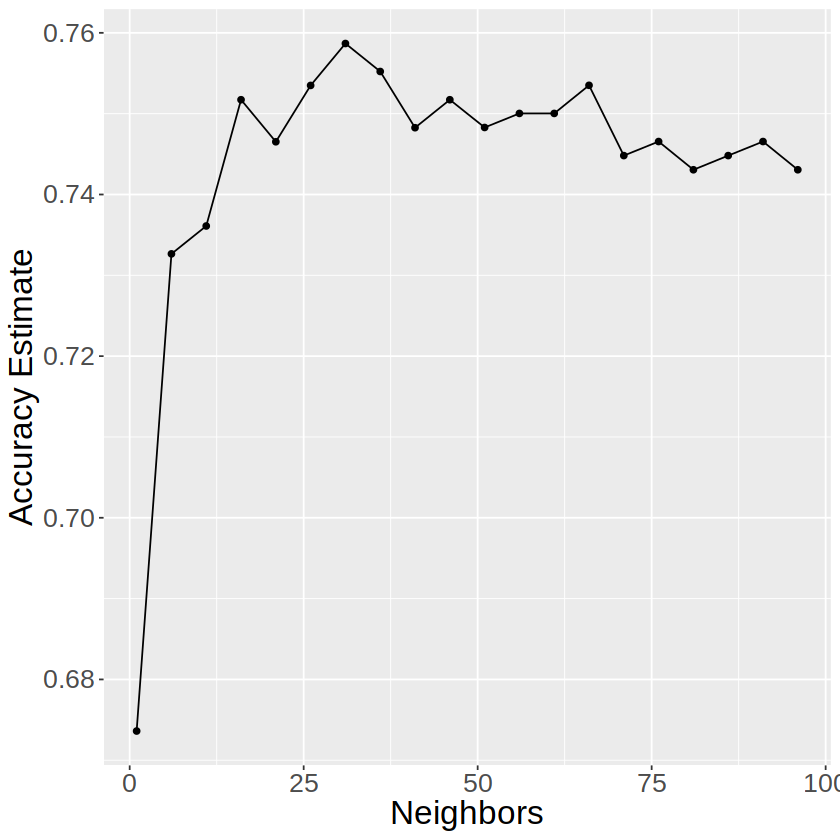

In [18]:

accuracies <- knn_results |>
                 filter(.metric == "accuracy") |>
                 mutate(mean = as.numeric(mean), neighbors = as.numeric(neighbors))
cross_val_plot <- accuracies |>
                  ggplot(aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(x = "Neighbors", y = "Accuracy Estimate") +
                  theme(text = element_text(size = 20))     
cross_val_plot

On the previous graph, when k = 31, the classification model gives the highest accuracy, so we will use this best k value to perform the classification again. First we using the best K to create a K-nearest model. Then, we recreate a workflow with this new model and fit the workflow with our training data set. And then we use this workflow with best k to make predictions on the testing data set. Finally, we calculate the accuracy of the classification result on the testing data set, and use a confusion matrix to visualize our result better.

In [30]:
set.seed(9999)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 30) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(diabete_recipe) |>
  add_model(knn_spec) |>
  fit(data = pimadata_training)

diabetes_predictions <- predict(knn_fit, pimadata_testing) |>
  bind_cols(pimadata_testing)

accuracy<-diabetes_predictions |>
  metrics(truth = Outcome, estimate = .pred_class) |>
  filter(.metric == "accuracy")|>
select(.estimate) |>
  pull()
accuracy

[1] 0.7395833

In [31]:
confusion <- diabetes_predictions |>
             conf_mat(truth = Outcome, estimate = .pred_class)
confusion

          Truth
Prediction   0   1
         0 112  37
         1  13  30

### Discussion
The first notable finding is the K value itself. Upon qualitative analysis of the elbow plot, we note that K = 31 is the most ideal K parameter for this dataset. This is an approximation, given that there were actually roughly relatively high accuracy between 25 to 60. We chose K = 31 because when you start decreasing the number of neighbors from 31, the WSSD accuracy decreases. This indicates that a k that is too small would causes under-fitting, or too few neighbors to look at near the observation, which is not ideal for a K-means classification model. When you start increasing the neighbours from 30, the accuracy does not change dramatically between 31 to 60, but a slow declining accuracy occurs due to the overfitting problem with a big K value, because when the K is too big, the number neighbors the model uses to predict the outcome of observation is too big, which is again not ideal. So no matter the K is bigger or smaller than 31, the accuracy gets lower. K = 31 is the most ideal one for out classification through our training process.

The next important finding was the answer to our research question: How well can we predict the likelihood of diabetes among Pima Indian women based on certain health-related features? There are a couple different metrics to consider to answer the question properly. Namely, accuracy, precision, and recall. We found the accuracy to be 0.7396 to four significant figures. It is difficult to determine whether or not this is a “good” accuracy, even if we consider literature. Due to different amounts of data available for training, different models, and the nature of the data itself, it is difficult to draw a fair comparison between this accuracy and others from other models.

Another important finding is related to the confusion matrix we generated. Along with accuracy, precision and recall are important features with which we can assess the quality of a model. Recall that Precision = True Positive/(True Positive + False Positive) = 30/(30 + 13) = 0.6977, and that Recall = True Positive/(True Positive + False Negative) = 30/(112 + 30) = 0.2113. Notice that these values are relatively weak. Notice as well that, when predicting diabetes in a practical setting, we care more about the cases that were positive but tested negative, or false negatives, rather than the negative cases that tested positive, or false positives. For the future, therefore, when seeking to improve the model by passing higher quality data of higher quantity, because there is a tradeoff between precision and recall inherent to supervised, machine learning models, we should aim to increase recall at the cost of precision. Especially since, as it is, a recall value of 0.2113 is poor, and indicates that this model should not be implemented as it is. Further, this analysis suggests that we can not predict well the likelihood of diabetes among Pima Indian women based on certain health-related features, as answer to our question. Note that this is only with respect to this study and the specific techniques and parameter specifications (variables, etc.) used.

The graphical representation highlights a notable presence of outliers within both diabetic and non-diabetic groups. It is clear that diabetic individuals generally exhibit elevated glucose levels in comparison to their non-diabetic counterparts. Specifically, non-diabetic subjects tend to fall within the glucose range of 50-150, whereas diabetic patients typically register glucose levels within the range of 100-200. This observation underscores a distinct pattern associating higher glucose levels with diabetes. The identification of these trends in glucose levels provides valuable insights into the potential significance of elevated glucose as a distinguishing factor between diabetic and non-diabetic populations.

Notice that the relatively poor performance of this model could also be attributed to the specific variables we (arbitrarily) chose to train our model with. In the future, further analysis should be done involving trying different combinations of predictor variables to train our model with and creating data visualizations for comparing recall, precision, and accuracy, as there would naturally be a set of variables that have high correlation with the outcome of having diabetes.

This is indeed what we expected to find. Given that we chose the predictor variables arbitrarily, there was no reason to expect that we would produce a good model. Additionally, the number of data observations (~570) the model was trained on is limited. Not only is the quantity important, but the quality of the data is as well. It is important to have well-sampled and representative data observations for machine learning models to be trained on. In this case, since we were limited to using an open, public dataset with no explanation of the sourcing of the data, we knew that the quality of the data itself was questionable. Hence, the results are not surprising.

An important impact of these findings relates to how we showed that not all possible sets of predictor variables are equal, and how it is not necessarily the case that the more variables the better. This project was a case in which an arbitrarily large set of variables led to poor results. Future studies should confirm this. Namely, by, as suggested, running different models with different sets of predictor variables and comparing the results. From there, the optimal set of predictor variables can be determined, and ultimately a better model can be constructed that can better predict diabetes in Pima Indian women. In the future, it is also possible to try different machine learning models and compare them to the K-neighbors classification algorithm adopted in this project. Simple feedforward neural networks, or multilayer perceptrons, for instance, could be used instead, as deep learning models have achieved state-of-the-art performance in many classification tasks (Li et al., 2022).


### References
Banday, Mujeeb Z, et al. “Pathophysiology of Diabetes: An Overview.” Avicenna Journal of Medicine, U.S.    
> National Library of Medicine, 13 Oct. 2020,  
www.ncbi.nlm.nih.gov/pmc/articles/PMC7791288/#:~:text=Diabetes%20mellitus%20is%20a%20chronic,or%20insulin%20action%20or%20both. Accessed December 6, 2023.

Li, Miles Q., et al. “On the Effectiveness of Interpretable Feedforward Neural Network.” On the Effectiveness of  
> Interpretable Feedforward Neural Network, 2022,  
dmas.lab.mcgill.ca/fung/pub/LFA22ijcnn_postprint.pdf. Accessed December 6, 2023.

<u>Data source:</u> <br>
Learning, UCI Machine. “Pima Indians Diabetes Database.” Kaggle, 6 Oct. 2016,  
> www.kaggle.com/datasets/uciml/pima-indians-diabetes-database. Accessed December 6, 2023.
